# Vertical Profiles

## Q1: Frequency of stable conditions at SCP


## Q2: Correcting 15m/2m temps to 10m/1m (M-Tower)

- Log linear correction
- Potential temperature correction

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy

# OS interaction
import sys, pickle, os, yaml

# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# turbulence package
import turbpy
import turbpy.multiConst as mc

## Directories

In [2]:
# Project directory
dir_proj = '/Users/karllapo/proj/SnowHydro_OfflineTurb'
dir_print = os.path.join(dir_proj, 'graphics')

# Data
dir_data = os.path.join(dir_proj, 'data')
dir_snq = os.path.join(dir_data, 'SNQ')
dir_scp = os.path.join(dir_data, 'SCP')

# Model output
dir_model_ouptut = os.path.join(dir_proj, 'results')

In [15]:
os.chdir(dir_snq)
print(os.listdir())
print(os.getcwd())
print(dir_data)
print(dir_snq)
SNQ = xr.open_dataset('SnoqualmieObs.wy2013_wy2015.nc')

['SnoqualmieObs.wy2013.wy2015.nc']
/Users/karllapo/Desktop/proj/SnowHydro_OfflineTurb/data/SNQ
/Users/karllapo/proj/SnowHydro_OfflineTurb/data
/Users/karllapo/proj/SnowHydro_OfflineTurb/data/SNQ


FileNotFoundError: [Errno 2] No such file or directory: b'/Users/karllapo/Desktop/proj/SnowHydro_OfflineTurb/data/SNQ/SnoqualmieObs.wy2013_wy2015.nc'

# Open data

In [16]:
# -----------------------------------------------------------------
# SNQ
os.chdir(dir_snq)
SNQ = xr.open_dataset('SnoqualmieObs.wy2013.wy2015.nc')

# -----------------------------------------------------------------
# SCP
os.chdir(dir_scp)
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
SCP = xr.open_dataset('SCP.Mtower.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')
fluxObs_30min = fluxObs.resample(dim='time', how='mean', freq='30min')
fluxObs_Hour = fluxObs.resample(dim='time', how='mean', freq='H')

# Surface temperature from upwelling longwave
sigma = 5.67*10**-8.
emissivity = 0.98
Tsfc = (radObs.Rlw_out / (sigma * emissivity)) ** (1 / 4)
SCP['Tsfc'] = (('time'), Tsfc - 273.15)

# Wind
SCP['UBar_15m'] = (('time'), (SCP.U_15m_M**2 + SCP.V_15m_M**2)**(1. / 2.))
SCP['UBar_2m'] = (('time'), (SCP.u_2m_M**2 + SCP.v_2m_M**2)**(1. / 2.))
SCP['UBar_4m'] = (('time'), (SCP.u_4m_M**2 + SCP.v_4m_M**2)**(1. / 2.))
SCP['UBar_5m'] = (('time'), (SCP.u_5m_M**2 + SCP.v_5m_M**2)**(1. / 2.))
SCP['UBar_10m'] = (('time'), (SCP.u_10m_M**2 + SCP.v_10m_M**2)**(1. / 2.))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="30min").mean() 
  if sys.path[0] == '':
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="H").mean() 
  del sys.path[0]


### Stability

In [6]:
# --------------------------------------------------------------------------------------
# SNQ
RiBulk, _, _ = turbpy.bulkRichardson(SNQ.T6 + 273.15,
                                     SNQ.Tsrf + 273.15,
                                     SNQ.WIND,
                                     6. - SNQ.Snowdepth,
                                     False)
SNQ['RiBulk'] = RiBulk

# --------------------------------------------------------------------------------------
# SCP

# Potential temperature correction
tempVars = ['T_1m_M', 'T_4m_M', 'T_1_5m_M', 'T_6m_M', 'T_8m_M', 'T_15m_M']
tempHeights = np.array((1, 4, 5, 6, 8, 15))
for n, v in enumerate(tempVars):
    SCP[v] = SCP[v] + (0.01 * tempHeights[n])

# Bulk stability
RiBulk_15m,_,_ = turbpy.bulkRichardson(SCP.T_15m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_15m, 15.)
SCP['RiBulk_15m'] = RiBulk_15m
RiBulk_2m,_,_ = turbpy.bulkRichardson(SCP.T_1m_M + 273.15, SCP.Tsfc + 273.15, SCP.UBar_2m, 2.)
SCP['RiBulk_2m'] = RiBulk_2m

SCPind = np.nonzero((SCP.RiBulk_15m > 0.).values)

## SCP data availability

CSAT heights on M-Tower: 0.5m, 2m, 3m, 4m, 5m, 10m, 20m (maybe 1m)?
Slow response air temp sensors heights on M-Tower: 1.5m, 2.5m, 3m, 4m, 6m, 8m, 15m
2D sonic winds heights on M-Tower: 6m, 8m, 15m

## SNQ data availability

CSAT heights: kept around 2m above the snow surface
air temp: 6m

## Temperature corrections

Some of the air temperatures I want to use to force turbpy are not co-located vertically with the CSAT that will be used for evaluation. While it is a common assumption that $Q_h$ is constant with height (an underlying assumption in bulk and Monin-Obukhov methods), this is clearly not the case. The wind threshold in particular violates this assumption. Additionally, it is not uncommon for shallow cold pools to form. We can assume that on occasion the top observation may be outside the influence of the cold pool while the CSAT may be within the cold pool. To account for this we have few options. I lay those out below.

### Temperature gradients and Qh

- Using the potential temperature correction from Mahrt and Vickers (2004) and described in Oleson et al., (2013; the CLM technical note).

$\theta = T(z) + 0.01z$

No correction is applied to the ground (which makes sense, what would you call the potential temperature of the skin layer of the surface? You can't lift it).

### Log-linear corrections

Assume that T scales vertically with log(z)


In [19]:
SNQ

<xarray.Dataset>
Dimensions:  (time: 45741)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01 2012-10-01T00:30:00 ...
Data variables:
    precip   (time) float64 ...
    SWdwn    (time) float64 ...
    LWdwn    (time) float64 ...
    Tair     (time) float64 ...
    WIND     (time) float64 ...
    Press    (time) float64 ...
    QS       (time) float64 ...
    RH       (time) float64 ...
    Tdew     (time) float64 ...
    Tsurf    (time) float64 ...

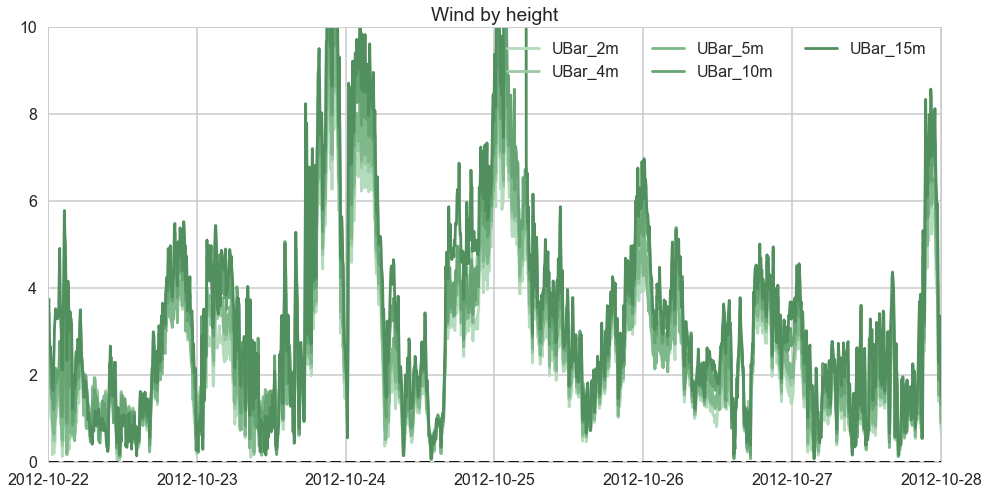

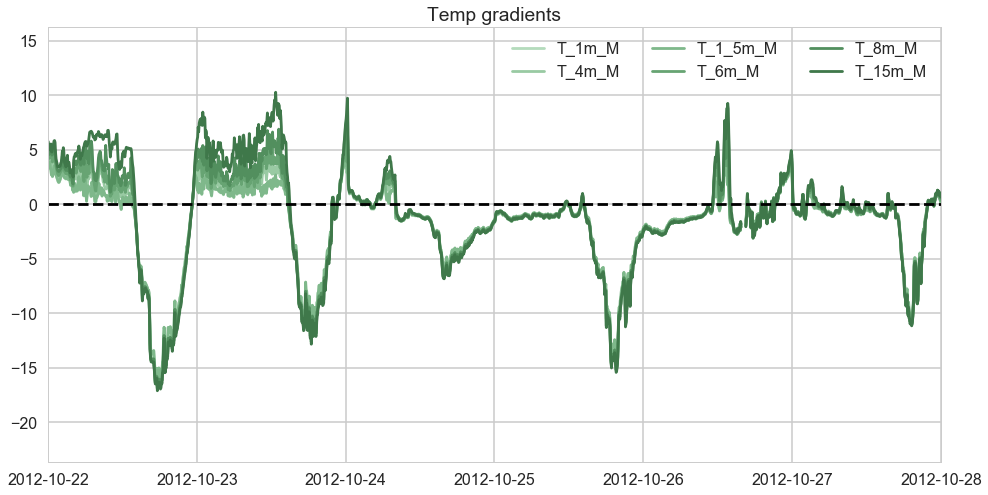

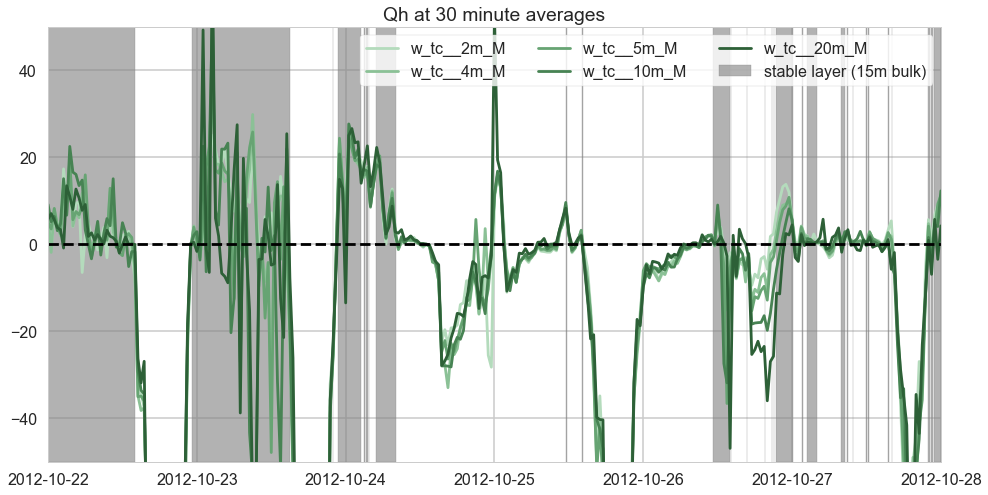

In [5]:
# ----------------------------------------------------------------------------------------
# Met variables and gradients by height
d1 = datetime(2012, 10, 22)
d2 = datetime(2012, 10, 28)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
pal2 = sns.cubehelix_palette(7, start=2, rot=0, dark=.3, light=.8)
windVars = ['UBar_2m', 'UBar_4m', 'UBar_5m', 'UBar_10m', 'UBar_15m']
for n, w in enumerate(windVars):
    ax.plot(SCP.time, SCP[w], label=w, color=pal2[n])
ax.set_xlim(d1, d2)
ax.plot([d1, d2], [0, 0], 'k--')
ax.legend(loc='best', ncol=3)
ax.set_ylim(0, 10)
ax.set_title('Wind by height')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
pal2 = sns.cubehelix_palette(7, start=2, rot=0, dark=.3, light=.8)
tempVars = ['T_1m_M', 'T_4m_M', 'T_1_5m_M', 'T_6m_M', 'T_8m_M', 'T_15m_M']
tempHeights = np.array((1, 4, 5, 6, 8, 15))
for n, v in enumerate(tempVars):
    ax.plot(SCP.time, (SCP[v] + (0.01 * tempHeights[n]) - SCP.Tsfc), label=v, color=pal2[n])
ax.set_xlim(d1, d2)
ax.plot([d1, d2], [0, 0], 'k--')
ax.legend(loc='best', ncol=3)
ax.set_title('Temp gradients')

# Qh by height
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
pal2 = sns.cubehelix_palette(5, start=2, rot=0, dark=.3, light=.8)
sensVars = ['w_tc__2m_M', 'w_tc__4m_M', 'w_tc__5m_M', 'w_tc__10m_M', 'w_tc__20m_M']
for n, q in enumerate(sensVars):
    ax.plot(fluxObs_30min.time, -fluxObs_30min[q], label=q, color=pal2[n])
    ax.set_ylim(-50, 50)
ax.fill_between(SCP.time.values, -50, 50,
                where=(SCP.T_15m_M - SCP.Tsfc) > 0,
                color='grey', alpha=.6, label='stable layer (15m bulk)')
ax.plot([d1, d2], [0, 0], 'k--')
ax.set_xlim(d1, d2)
ax.legend(loc='best', ncol=3, frameon=True)
ax.set_title('Qh at 30 minute averages')

# # Qh by height
# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# pal2 = sns.cubehelix_palette(5, start=2, rot=0, dark=.3, light=.8)
# sensVars = ['w_tc__2m_M', 'w_tc__4m_M', 'w_tc__5m_M', 'w_tc__10m_M', 'w_tc__20m_M']
# for n, q in enumerate(sensVars):
#     ax.plot(fluxObs_Hour.time, -fluxObs_Hour[q], label=q, color=pal2[n])
#     ax.set_ylim(-50, 50)
# ax.fill_between(SCP.time.values, -50, 50,
#                 where=(SCP.T_15m_M + (0.01 * 15) - SCP.Tsfc) > 0,
#                 color='grey', alpha=.6, label='stable layer (15m bulk)')
# ax.plot([d1, d2], [0, 0], 'k--')
# ax.set_xlim(d1, d2)
# ax.legend(loc='best', ncol=3, frameon=True)
# ax.set_title('Hour averages')

The grey indicates times when the bulk stability is positive for the 20m observations. There do appear to be some times when the bulk stability is positive and Qh is negative and coherent with height. But, it seems rare. Maybe isolated to times when the boundary layer is transitioning?

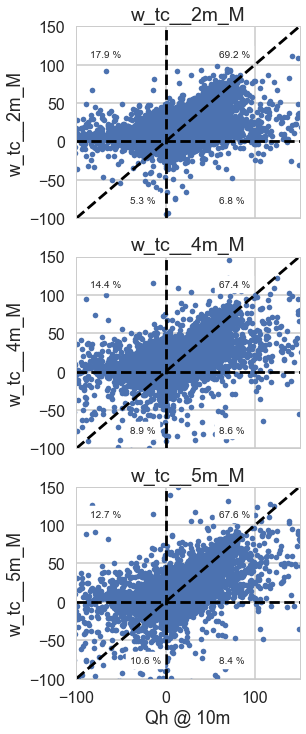

In [7]:
# -------------------------------------------------------------------------------------------------------
# 5 minute raw data
# Plot Qh at 10m against all other obs of Qh on the M-tower

# 5 minute
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(4, 12))
pal2 = sns.cubehelix_palette(6, start=2, rot=0, dark=.3, light=.8)
sensVars = ['w_tc__2m_M', 'w_tc__4m_M', 'w_tc__5m_M']
for n, q in enumerate(sensVars):
    ax = axes[n]
    # Observed Qh at two different heights
    ax.plot(-fluxObs.w_tc__10m_M[SCPind], -fluxObs[q][SCPind], '.')
    
    # zero lines and 1:1 line
    ax.plot([-100, 150], [-100, 150], 'k--')
    ax.set_title(q)
    ax.set_xlim(-100, 150)
    ax.set_ylim(-100, 150)
    ax.plot([0, 0], [-100, 150], 'k--')
    ax.plot([-100, 150], [0, 0], 'k--')
    
    # % of obs within each quadrant
    quad1 = ((-fluxObs.w_tc__10m_M[SCPind] < 0) & (-fluxObs[q][SCPind] > 0)).mean(dim='time')
    ax.text(-85, 110, '%2.1f' % (quad1 * 100) + ' %', backgroundcolor='w')
    quad2 = ((-fluxObs.w_tc__10m_M[SCPind] > 0) & (-fluxObs[q][SCPind] > 0)).mean(dim='time')
    ax.text(60, 110, '%2.1f' % (quad2 * 100) + ' %', backgroundcolor='w')
    quad3 = ((-fluxObs.w_tc__10m_M[SCPind] > 0) & (-fluxObs[q][SCPind] < 0)).mean(dim='time')
    ax.text(60, -80, '%2.1f' % (quad3 * 100) + ' %', backgroundcolor='w')
    quad4 = ((-fluxObs.w_tc__10m_M[SCPind] < 0) & (-fluxObs[q][SCPind] < 0)).mean(dim='time')
    ax.text(-40, -80, '%2.1f' % (quad4 * 100) + ' %', backgroundcolor='w')
    ax.set_ylabel(q)
    
ax.set_xlabel('Qh @ 10m')

Qh at 10m (x-axis in all subplots) vs Qh(z).
- Quadrant 1 = counter-gradient at 10m, with gradient at level z
- Quadrant 2 = with gradient at 10m and at level z
- Quadrant 3 = with gradient at 10m, counter-gradient at level z
- Quadrant 4 = Counter-gradient at both levels

Counter-gradient fluxes occur ~35% of the time at a single level, but only ~9% of the time does it appear that the counter-gradient flux is coherent with height.

The below graphs are the same as the above, but with 30 minute and 1 hour averages.

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


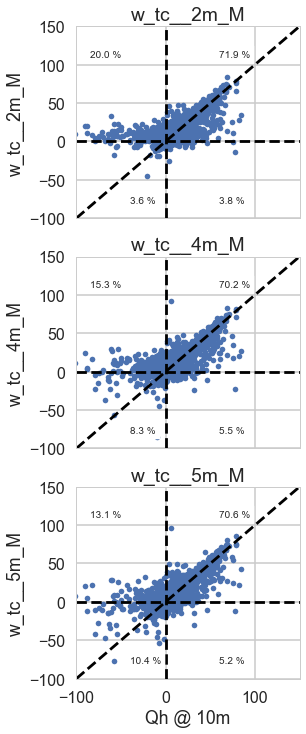

In [7]:
# -------------------------------------------------------------------------------------------------------
# Plot Qh at 10m against all other obs of Qh on the M-tower

# 30 minute
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(4, 12))
pal2 = sns.cubehelix_palette(6, start=2, rot=0, dark=.3, light=.8)
sensVars = ['w_tc__2m_M', 'w_tc__4m_M', 'w_tc__5m_M']
SCPind_30min = SCP.RiBulk_15m.resample(how='mean', dim='time', freq='30min') > 0
for n, q in enumerate(sensVars):
    ax = axes[n]
    # Observed Qh at two different heights
    ax.plot(-fluxObs_30min.w_tc__10m_M[SCPind_30min], -fluxObs_30min[q][SCPind_30min], '.')
    
    # zero lines and 1:1 line
    ax.plot([-100, 150], [-100, 150], 'k--')
    ax.set_title(q)
    ax.set_xlim(-100, 150)
    ax.set_ylim(-100, 150)
    ax.plot([0, 0], [-100, 150], 'k--')
    ax.plot([-100, 150], [0, 0], 'k--')
    
    # % of obs within each quadrant
    quad1 = ((-fluxObs_30min.w_tc__10m_M[SCPind_30min] < 0) & (-fluxObs_30min[q][SCPind_30min] > 0)).mean(dim='time')
    ax.text(-85, 110, '%2.1f' % (quad1 * 100) + ' %', backgroundcolor='w')
    quad2 = ((-fluxObs_30min.w_tc__10m_M[SCPind_30min] > 0) & (-fluxObs_30min[q][SCPind_30min] > 0)).mean(dim='time')
    ax.text(60, 110, '%2.1f' % (quad2 * 100) + ' %', backgroundcolor='w')
    quad3 = ((-fluxObs_30min.w_tc__10m_M[SCPind_30min] > 0) & (-fluxObs_30min[q][SCPind_30min] < 0)).mean(dim='time')
    ax.text(60, -80, '%2.1f' % (quad3 * 100) + ' %', backgroundcolor='w')
    quad4 = ((-fluxObs_30min.w_tc__10m_M[SCPind_30min] < 0) & (-fluxObs_30min[q][SCPind_30min] < 0)).mean(dim='time')
    ax.text(-40, -80, '%2.1f' % (quad4 * 100) + ' %', backgroundcolor='w')
    ax.set_ylabel(q)
    
ax.set_xlabel('Qh @ 10m')

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


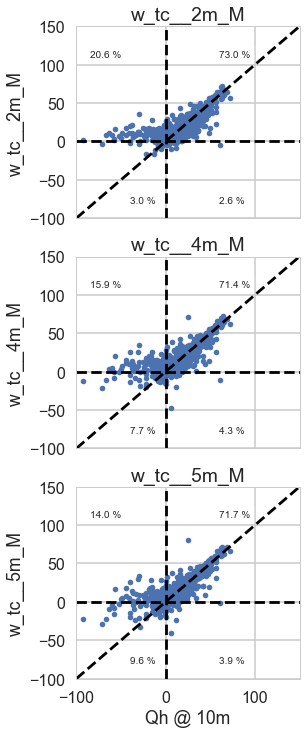

In [8]:
# -------------------------------------------------------------------------------------------------------
# Plot Qh at 10m against all other obs of Qh on the M-tower

# 30 minute
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(4, 12))
pal2 = sns.cubehelix_palette(6, start=2, rot=0, dark=.3, light=.8)
sensVars = ['w_tc__2m_M', 'w_tc__4m_M', 'w_tc__5m_M']
SCPind_Hour = SCP.RiBulk_15m.resample(how='mean', dim='time', freq='H') > 0
for n, q in enumerate(sensVars):
    ax = axes[n]
    # Observed Qh at two different heights
    ax.plot(-fluxObs_Hour.w_tc__10m_M[SCPind_Hour], -fluxObs_Hour[q][SCPind_Hour], '.')
    
    # zero lines and 1:1 line
    ax.plot([-100, 150], [-100, 150], 'k--')
    ax.set_title(q)
    ax.set_xlim(-100, 150)
    ax.set_ylim(-100, 150)
    ax.plot([0, 0], [-100, 150], 'k--')
    ax.plot([-100, 150], [0, 0], 'k--')
    
    # % of obs within each quadrant
    quad1 = ((-fluxObs_Hour.w_tc__10m_M[SCPind_Hour] < 0) & (-fluxObs_Hour[q][SCPind_Hour] > 0)).mean(dim='time')
    ax.text(-85, 110, '%2.1f' % (quad1 * 100) + ' %', backgroundcolor='w')
    quad2 = ((-fluxObs_Hour.w_tc__10m_M[SCPind_Hour] > 0) & (-fluxObs_Hour[q][SCPind_Hour] > 0)).mean(dim='time')
    ax.text(60, 110, '%2.1f' % (quad2 * 100) + ' %', backgroundcolor='w')
    quad3 = ((-fluxObs_Hour.w_tc__10m_M[SCPind_Hour] > 0) & (-fluxObs_Hour[q][SCPind_Hour] < 0)).mean(dim='time')
    ax.text(60, -80, '%2.1f' % (quad3 * 100) + ' %', backgroundcolor='w')
    quad4 = ((-fluxObs_Hour.w_tc__10m_M[SCPind_Hour] < 0) & (-fluxObs_Hour[q][SCPind_Hour] < 0)).mean(dim='time')
    ax.text(-40, -80, '%2.1f' % (quad4 * 100) + ' %', backgroundcolor='w')
    ax.set_ylabel(q)
    
ax.set_xlabel('Qh @ 10m')

# Frequency of Counter-gradient fluxes
Fraction of stable conditions during a given hour that are counter-gradient

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


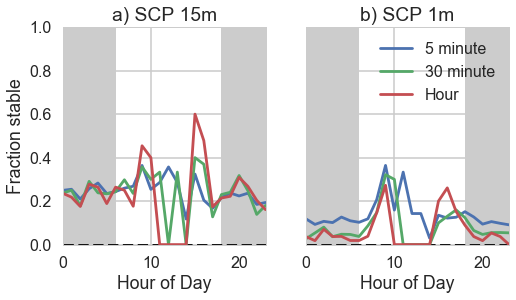

In [9]:
# Format figure
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
os.chdir(dirPrint)
hours = np.arange(0, 24)

# -------------------------------------------------------------------------------------------------------
# SCP - 15m
ax = axes[0]
ymin = 0
ymax = 1
xmin = 0
xmax = 23

# Zero line for visual reference
ax.plot([xmin, xmax], [0, 0], 'k--')

# Nighttime
ax.fill_between(np.arange(0, 7), ymin, ymax, facecolor='0.8')
ax.fill_between(np.arange(18, 24), ymin, ymax, facecolor='0.8')
ax.plot(hours,
        (-fluxObs.w_tc__10m_M[SCPind] < 0).groupby('time.hour').mean(dim='time').roll(hour=-6),
        label='5 minute')
ax.plot(hours,
        (-fluxObs_30min.w_tc__10m_M[SCPind_30min] < 0).groupby('time.hour').mean(dim='time').roll(hour=-6),
        label='30 minute')
ax.plot(hours,
        (-fluxObs_Hour.w_tc__10m_M[SCPind_Hour] < 0).groupby('time.hour').mean(dim='time').roll(hour=-6),
        label='Hour')

# Format
# ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_ylabel('Fraction stable')
ax.set_xlabel('Hour of Day')
ax.set_title('a) SCP 15m')

# -------------------------------------------------------------------------------------------------------
# SCP - 1m
ax = axes[1]
ymin = 0
ymax = 1
xmin = 0
xmax = 23

# Zero line for visual reference
ax.plot([xmin, xmax], [0, 0], 'k--')

# Nighttime
ax.fill_between(np.arange(0, 7), ymin, ymax, facecolor='0.8')
ax.fill_between(np.arange(18, 24), ymin, ymax, facecolor='0.8')
# Observations
ax.plot(hours, 
        (-fluxObs.w_tc__2m_M[SCPind] < 0).groupby('time.hour').mean(dim='time').roll(hour=-6),
        label='5 minute')
ax.plot(hours, 
        (-fluxObs_30min.w_tc__2m_M[SCPind_30min] < 0).groupby('time.hour').mean(dim='time').roll(hour=-6),
        label='30 minute')
ax.plot(hours, 
        (-fluxObs_Hour.w_tc__2m_M[SCPind_Hour] < 0).groupby('time.hour').mean(dim='time').roll(hour=-6),
        label='Hour')

# Format
ax.legend(loc='best')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Hour of Day')
ax.set_title('b) SCP 1m')


//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


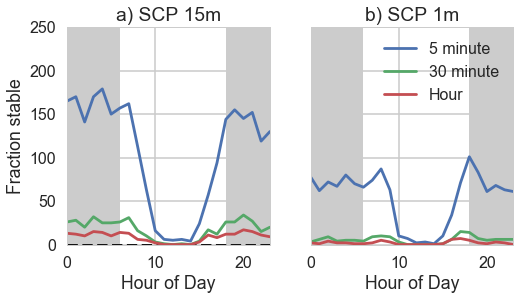

In [10]:
# Format figure
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
os.chdir(dirPrint)
hours = np.arange(0, 24)

# -------------------------------------------------------------------------------------------------------
# SCP - 15m
ax = axes[0]
ymin = 0
ymax = 250
xmin = 0
xmax = 23

# Zero line for visual reference
ax.plot([xmin, xmax], [0, 0], 'k--')

# Nighttime
ax.fill_between(np.arange(0, 7), ymin, ymax, facecolor='0.8')
ax.fill_between(np.arange(18, 24), ymin, ymax, facecolor='0.8')
ax.plot(hours,
        (-fluxObs.w_tc__10m_M[SCPind] < 0).groupby('time.hour').sum(dim='time').roll(hour=-6),
        label='5 minute')
ax.plot(hours,
        (-fluxObs_30min.w_tc__10m_M[SCPind_30min] < 0).groupby('time.hour').sum(dim='time').roll(hour=-6),
        label='30 minute')
ax.plot(hours,
        (-fluxObs_Hour.w_tc__10m_M[SCPind_Hour] < 0).groupby('time.hour').sum(dim='time').roll(hour=-6),
        label='Hour')

# Format
# ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_ylabel('Fraction stable')
ax.set_xlabel('Hour of Day')
ax.set_title('a) SCP 15m')

# -------------------------------------------------------------------------------------------------------
# SCP - 1m
ax = axes[1]
ymin = 0
# ymax = 150
xmin = 0
xmax = 23

# Nighttime
ax.fill_between(np.arange(0, 7), ymin, ymax, facecolor='0.8')
ax.fill_between(np.arange(18, 24), ymin, ymax, facecolor='0.8')
# Observations
ax.plot(hours, 
        (-fluxObs.w_tc__2m_M[SCPind] < 0).groupby('time.hour').sum(dim='time').roll(hour=-6),
        label='5 minute')
ax.plot(hours, 
        (-fluxObs_30min.w_tc__2m_M[SCPind_30min] < 0).groupby('time.hour').sum(dim='time').roll(hour=-6),
        label='30 minute')
ax.plot(hours, 
        (-fluxObs_Hour.w_tc__2m_M[SCPind_Hour] < 0).groupby('time.hour').sum(dim='time').roll(hour=-6),
        label='Hour')

# Format
ax.legend(loc='best')
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_xlabel('Hour of Day')
ax.set_title('b) SCP 1m')


So what's happening here? I've changed the aggregation from mean to sums. At 15m (10m?) the largest number of counter-gradient fluxes do not occur during the day but that the day sees the largest fraction of stable times with counter-gradient fluxes.
- How do we get counter-gradient fluxes at night? Probably through Chrisoph's sub-mesoscale motions.
- The peaks in the 1m (2m) observations suggests that there is a diurnal role. But this could also be the result of the boundary layer undergoing a transition between stable/unstable

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


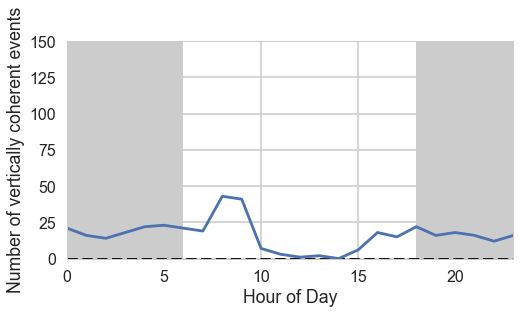

In [11]:
# Format figure
fig, axes = plt.subplots(1, 1, sharey=True, figsize=(8, 4))
os.chdir(dirPrint)
hours = np.arange(0, 24)

# -------------------------------------------------------------------------------------------------------
# SCP - 15m
ax = axes
ymin = 0
ymax = 150
xmin = 0
xmax = 23

# Zero line for visual reference
ax.plot([xmin, xmax], [0, 0], 'k--')

# Nighttime
ax.fill_between(np.arange(0, 7), ymin, ymax, facecolor='0.8')
ax.fill_between(np.arange(18, 24), ymin, ymax, facecolor='0.8')
ax.plot(hours,
        (  (-fluxObs.w_tc__10m_M[SCPind] < 0)
         & (-fluxObs.w_tc__4m_M[SCPind] < 0)
         & (-fluxObs.w_tc__5m_M[SCPind] < 0)
         & (-fluxObs.w_tc__2m_M[SCPind] < 0)).groupby('time.hour').sum(dim='time').roll(hour=-6),
        label='5 minute')

# Format
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
ax.set_ylabel('Number of vertically coherent events')
ax.set_xlabel('Hour of Day')

os.chdir(dirPrint)
fig.savefig('TF.VerticallyCoherent_CounterGradient.png')
fig.savefig('TF.VerticallyCoherent_CounterGradient.pdf')


Ok, here we finally get down to the meat of it. The counter-gradient fluxes that are vertically coherent are most likely to occur during the morning and evening transition. I think this gives a lot of ammunition to the heterogeneous land surface temperature argument.

In [ ]:
# -------------------------------------------------------------------------------------------------------
# Mean temperature profiles
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
tempVars = ['Tsfc', 'T_1m_M', 'T_4m_M', 'T_1_5m_M', 'T_6m_M', 'T_8m_M', 'T_15m_M']
heights = np.array((0, 1, 4, 5, 6, 8, 15))
meanTempProfile = []
for tV in tempVars:
    meanTempProfile.append(SCP[tV].where(SCPind).mean(dim='time').values)
np.asanyarray(meanTempProfile)
ds = xr.Dataset()
ds['t_profile'] = (('height'), meanTempProfile)
ds.coords['height'] = heights

ax.plot(ds['t_profile'] + (0.01 * ds['height']), ds['height'], marker='o')
ax.plot([ds.isel(height=0)['t_profile'], ds.isel(height=6)['t_profile'] + 0.01 * 15], [0, 15], 'k--')

# # Qh by height
# sensVars = ['w_tc__2m_M', 'w_tc__4m_M', 'w_tc__5m_M', 'w_tc__10m_M', 'w_tc__20m_M']



ValueError: conflicting sizes for dimension 'height': length 7 on 'height' and length 5 on 'Qh_profile'

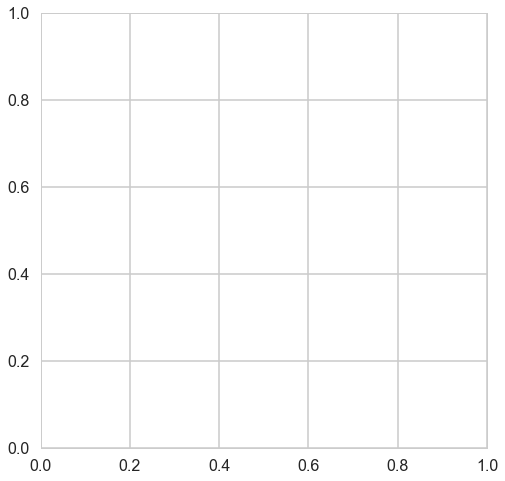

In [13]:
# -------------------------------------------------------------------------------------------------------
# Mean temperature profiles
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sensVars = ['w_tc__2m_M', 'w_tc__4m_M', 'w_tc__5m_M', 'w_tc__10m_M', 'w_tc__20m_M']
heights = np.array((0, 1, 4, 5, 6, 8, 15))
meanQhProfile = []
for sV in sensVars:
    meanQhProfile.append(fluxObs[sV].mean(dim='time').values)
np.asanyarray(meanQhProfile)
ds = xr.Dataset()
ds['Qh_profile'] = (('height'), meanQhProfile)
ds.coords['height'] = heights

ax.plot(ds['Qh_profile'], ds['height'], '-.')

# # Qh by height

